In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# https://colab.research.google.com/drive/1VGZ3WLZ2iEgnRv5VD6uD6MtmCRvDauP0?usp=sharing
import re 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker
from scipy.stats import gamma

In [2]:
outcomes= pd.read_csv('Austin_Animal_Center_Outcomes.csv')
intakes=pd.read_csv('Austin_Animal_Center_Intakes.csv')

### удалим дубликаты, их оказалось немало
outcomes = outcomes.drop_duplicates(subset=['Animal ID'],keep='last')
intakes = intakes.drop_duplicates(subset=['Animal ID'],keep='last')


In [3]:
### Смотрим, что у нас по пропускам
### на пропуски в Name внимание можно не обращать
### а вот Outcome Subtype создает проблемы
(outcomes.isna().mean( ) * 100).round(2)
print(len(outcomes))

132519


In [4]:

### заполняем пропуски в Outcome Subtype 
outcomes.loc[(outcomes['Outcome Subtype'].isna())&(outcomes['Outcome Type']=='Adoption'),'Outcome Subtype'] = 'Foster'
outcomes.loc[(outcomes['Outcome Subtype'].isna())&(outcomes['Outcome Type']=='Return to Owner'),'Outcome Subtype'] = 'Field'
outcomes.loc[(outcomes['Outcome Subtype'].isna())&(outcomes['Outcome Type']=='Euthanasia'),'Outcome Subtype'] = 'Rabies Risk'
outcomes.loc[(outcomes['Outcome Subtype'].isna())&(outcomes['Outcome Type']=='Died'),'Outcome Subtype'] = 'In Kennel'
outcomes.loc[(outcomes['Outcome Subtype'].isna())&(outcomes['Outcome Type']=='Missing'),'Outcome Subtype'] = 'In Foster'

outcomes = outcomes[(outcomes['Sex upon Outcome']!= 'Unknown') & (outcomes['Breed']!= 'Unknown') & (outcomes['Animal Type']!= 'Unknown')]
outcomes.dropna(subset=["Outcome Subtype"],axis=0,inplace = True)

### после зачистки данных у нас осталось 120 тысяч строк
print(len(outcomes))


120103


In [5]:
print('Проценты по пропускам в столбцах',(outcomes.isna().mean( ) * 100).round(2))
print()
print('Теперь всего пропусков в Outcome Subtype единиц',len(outcomes[outcomes['Outcome Subtype'].isna()]))

Проценты по пропускам в столбцах Animal ID            0.00
Name                26.21
DateTime             0.00
MonthYear            0.00
Date of Birth        0.00
Outcome Type         0.00
Outcome Subtype      0.00
Animal Type          0.00
Sex upon Outcome     0.00
Age upon Outcome     0.00
Breed                0.00
Color                0.00
dtype: float64

Теперь всего пропусков в Outcome Subtype единиц 0


In [6]:
outcomes.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,Foster,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
6,A814515,Quentin,05/06/2020 07:59:00 AM,May 2020,03/01/2018,Adoption,Foster,Dog,Neutered Male,2 years,American Foxhound/Labrador Retriever,White/Brown
7,A860161,*Lalo,07/19/2022 03:53:00 PM,Jul 2022,05/04/2022,Adoption,Foster,Cat,Neutered Male,2 months,Domestic Shorthair,Brown Tabby
8,A689724,*Donatello,10/18/2014 06:52:00 PM,Oct 2014,08/01/2014,Adoption,Foster,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


In [7]:
### сразу преобразуем данные для дальнейших операций с моделями
### сгененрируем из столбцов даты раождения и даты перерегистрации по изменению статуса переменную возраст в днях

outcomes['Date of Birth'] = outcomes['Date of Birth'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))

outcomes['DateTime'] = outcomes['DateTime'].apply(lambda x: re.findall(r'\d{2}/\d{2}/\d{4}', x)[0])

outcomes['DateTime'] = outcomes['DateTime'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))
outcomes['Age'] = (outcomes['DateTime'] - outcomes['Date of Birth'])

### отчистим переменную от слова "days"
outcomes['Age'] = outcomes['Age'].astype(str)
outcomes['Age'] = outcomes['Age'].apply(lambda x: x.split(' ')[0]).astype(int)
outcomes['Age'] = outcomes['Age'].astype('int64')
outcomes['Age'] = outcomes['Age'].apply(lambda x: x//365)


In [8]:
outcomes[outcomes['DateTime']<=datetime.strptime('Dec 2022','%b %Y')]

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Age
1,A776359,Gizmo,2018-07-18,Jul 2018,2017-07-12,Adoption,Foster,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown,1
4,A674754,NaN,2014-03-18,Mar 2014,2014-03-12,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,0
6,A814515,Quentin,2020-05-06,May 2020,2018-03-01,Adoption,Foster,Dog,Neutered Male,2 years,American Foxhound/Labrador Retriever,White/Brown,2
7,A860161,*Lalo,2022-07-19,Jul 2022,2022-05-04,Adoption,Foster,Cat,Neutered Male,2 months,Domestic Shorthair,Brown Tabby,0
8,A689724,*Donatello,2014-10-18,Oct 2014,2014-08-01,Adoption,Foster,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147890,A862507,Princess,2022-07-28,Jul 2022,2022-05-27,Return to Owner,Field,Dog,Intact Female,2 months,American Bulldog,White/Black,0
147894,A868479,Benji,2022-11-04,Nov 2022,2019-10-25,Return to Owner,Field,Dog,Neutered Male,3 years,Pit Bull Mix,Tan/White,3
147898,A829738,Nelson,2021-03-01,Mar 2021,2020-10-07,Adoption,Foster,Dog,Neutered Male,4 months,Great Dane/Labrador Retriever,Brown/Black,0
147900,A843493,Magic,2021-10-08,Oct 2021,2016-01-25,Adoption,Foster,Dog,Neutered Male,5 years,Labrador Retriever Mix,Black/White,5


In [9]:
### проверим нет ли некорректных значений по возрасту
outcomes.loc[outcomes['Age']<0,'Age'] = 0
outcomes[outcomes['Age']<0]

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Age


In [10]:
### Ситуация по пропускам в intakes хорошая
(intakes.isna().mean()*100)

Animal ID            0.000000
Name                32.164958
DateTime             0.000000
MonthYear            0.000000
Found Location       0.000000
Intake Type          0.000000
Intake Condition     0.000000
Animal Type          0.000000
Sex upon Intake      0.001511
Age upon Intake      0.000756
Breed                0.000000
Color                0.000000
dtype: float64

## Приступим к визуализациям

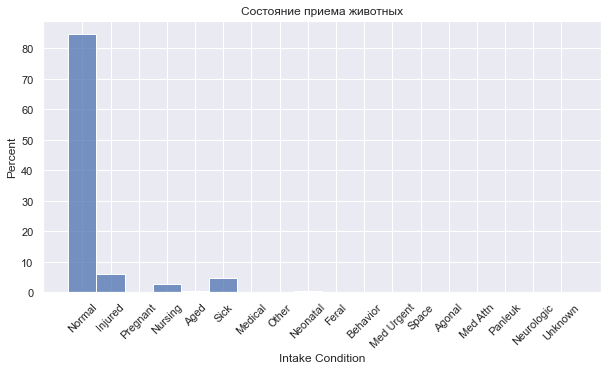

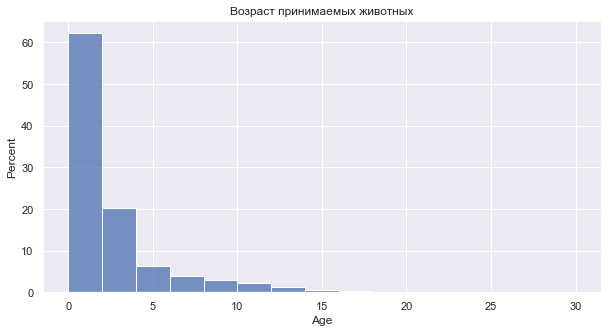

In [11]:
plt.rcParams['figure.figsize']=10,5
sns.set_theme()
sns.histplot(intakes["Intake Condition"],stat='percent').set (title='Состояние приема животных') 
plt.xticks(rotation=45);
plt.show()
sns.histplot(outcomes["Age"],stat='percent',bins=15).set (title='Возраст принимаемых животных'); 

In [12]:
outcomes['MonthYear'] = outcomes['MonthYear'].apply(lambda x: datetime.strptime(x,'%b %Y'))
plot = outcomes[(outcomes['Outcome Type']=='Adoption') | (outcomes['Outcome Type']=='Return to Owner')]

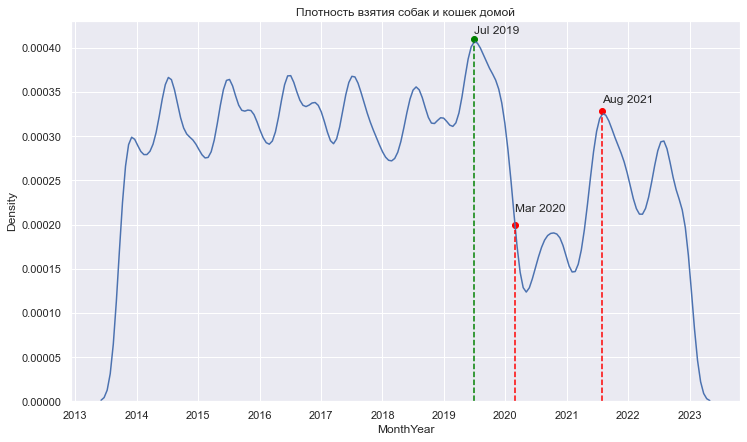

In [13]:

plt.rcParams['figure.figsize']=(12,7)


ax = sns.kdeplot(data = plot['MonthYear'].sort_values(),bw_adjust=.4) 

# sns.kdeplot(data = d['MonthYear'].sort_values(),bw_adjust=.4,common_grid=False) 
plt.axvline (x=datetime.strptime('Jul 2019','%b %Y'),ymax=0.95, color='green', linestyle='--') 

plt.axvline (x=datetime.strptime('Mar 2020','%b %Y'), color='red',ymax=0.45, linestyle='--') 
plt.axvline (x=datetime.strptime('Aug 2021','%b %Y'),ymax=0.758, color='red', linestyle='--')

plt.scatter(datetime.strptime('Mar 2020','%b %Y'), 0.00020, c='red')
plt.scatter(datetime.strptime('Aug 2021','%b %Y'), 0.000328, c='red')
plt.scatter(datetime.strptime('Jul 2019','%b %Y'), 0.00041, c='green')

ax.text(datetime.strptime('Jul 2019','%b %Y'), 0.00041555,'Jul 2019',size=12)
ax.text(datetime.strptime('Aug 2021','%b %Y'), 0.000338,'Aug 2021',size=12)
ax.text(datetime.strptime('Mar 2020','%b %Y'), 0.000215,'Mar 2020',size=12)
ax.set(title='Плотность взятия собак и кошек домой'); 

* Судя по всему очередной циклический спад взятия животных домой начался в июле 2019 г.
* Судя по графику взятия собак и кошек с марта 2020 г. действительно наблюдается спад по сравнению с предыдущими периодами
* Однако вызывает вопросы граница начала спада, спад перешел в аномально низкие значения еще до начала локдауна в середине марта 2020
* Также лично мне встречались статьи, что в этот период наоборот люди брали чаще себе животных для избежания одиночества
* Подтверждения этой гипотезы на графике не найдено, поэтому констатируем, что во **время пандемии** действительно **был спад**

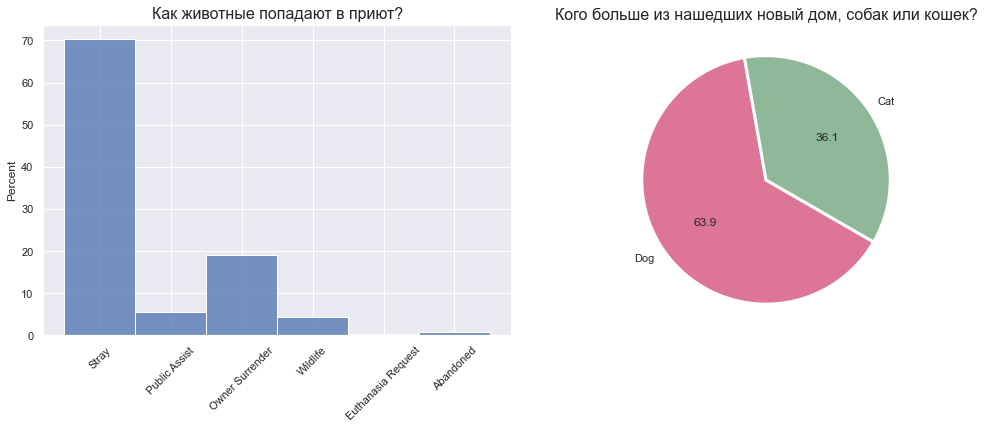

In [14]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.tight_layout(h_pad= 5 )

sns.histplot(intakes["Intake Type"],stat='percent')
plt.xticks(rotation=45);
plt.title('Как животные попадают в приют?',fontsize=16);
plt.xlabel('')

plt.subplot(1, 2, 2)
plt.pie(plot[(plot['Animal Type']=='Dog')|(plot['Animal Type']=='Cat')]['Animal Type'].value_counts(),\
        labels=['Dog','Cat'],autopct='%.1f',\
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },colors=['#DD7596', '#8EB897'],startangle = 100)
plt.title('Кого больше из нашедших новый дом, собак или кошек?',fontsize=16);


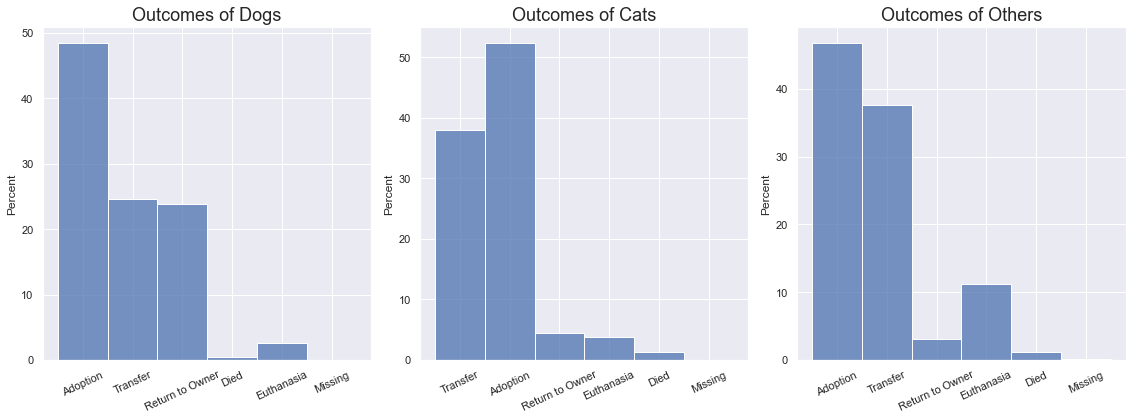

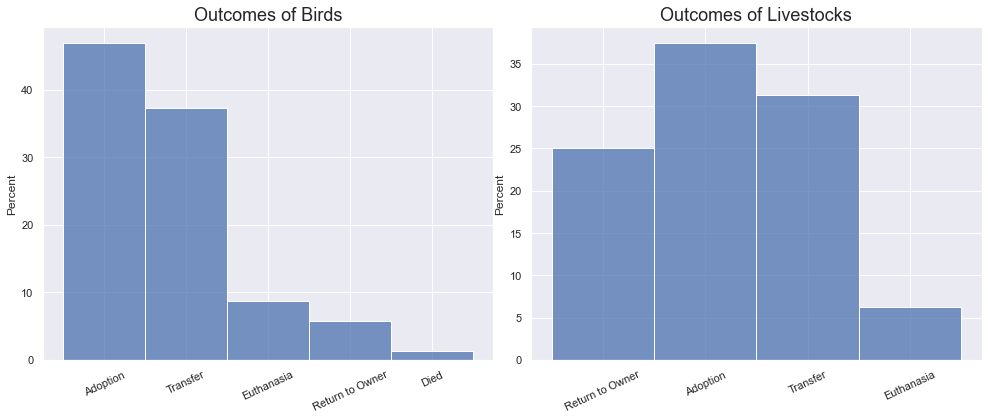

In [15]:
###  Посмотрим, как разные животные покидают приют
plt.figure(figsize=(16, 6))
for item, i in enumerate(outcomes['Animal Type'].unique()[0:3]):
        plt.subplot(1, 3, item+1)
        plt.tight_layout(h_pad= 5 )
        sns.histplot(outcomes[outcomes['Animal Type']==i]['Outcome Type'],stat='percent')
        plt.title(f'Outcomes of {i}s',fontsize=18)
        plt.xticks(rotation=25);
        plt.xlabel('')
plt.show()      
plt.figure(figsize=(14, 6))
for item, i in enumerate(outcomes['Animal Type'].unique()[3:]):
        plt.subplot(1, 2, item+1)
        plt.tight_layout(h_pad= 5 )
        sns.histplot(outcomes[outcomes['Animal Type']==i]['Outcome Type'],stat='percent')
        plt.title(f'Outcomes of {i}s',fontsize=18)
        plt.xticks(rotation=25);
        plt.xlabel('')
    

## Переходим к построению логистической модели

In [17]:
### создаем единый фрейм из intakes и outcomes
outcomes_2 = outcomes.drop(['MonthYear','Name','Date of Birth','Age upon Outcome','DateTime','Outcome Subtype'],axis=1)
joined = intakes[['Animal ID','Intake Condition']].merge(outcomes_2,how='inner',on='Animal ID')

### классифицируем животных по типу судьбы: заберут или не заберут из приюта (Outcome Type)
joined.loc[(joined['Outcome Type'].isin(['Adoption', 'Return to Owner'])), 'Outcome Type'] = 'Yes'

joined.loc[(joined['Outcome Type']\
            .isin(['Transfer', 'Euthanasia','Disposal','Died','Rto-Adopt','Missing'])),'Outcome Type'] = 'No'

In [18]:
joined.head()

,Animal ID,Intake Condition,Outcome Type,Animal Type,Sex upon Outcome,Breed,Color,Age
0,A786884,Normal,No,Dog,Neutered Male,Beagle Mix,Tricolor,2
1,A706918,Normal,Yes,Dog,Spayed Female,English Springer Spaniel,White/Liver,8
2,A724273,Normal,Yes,Dog,Neutered Male,Basenji Mix,Sable/White,1
3,A857105,Normal,No,Cat,Neutered Male,Domestic Shorthair,Orange Tabby,2
4,A682524,Normal,Yes,Dog,Neutered Male,Doberman Pinsch/Australian Cattle Dog,Tan/Gray,4


In [19]:
### 'Intake Condition','Outcome Subtype', 'Sex upon Outcome','Breed','Animal Type' не имеют естественного порядка
### поэтому преобразуем их с помощью one-hot encoding
features = ['Intake Condition','Animal Type','Sex upon Outcome','Breed']

data = pd.get_dummies(joined, columns=features).drop(['Animal ID','Color'],axis=1).fillna(0) 
data = data[data['Outcome Type']!= 0]
data

,Outcome Type,Age,Intake Condition_Aged,Intake Condition_Behavior,Intake Condition_Feral,Intake Condition_Injured,Intake Condition_Med Attn,Intake Condition_Med Urgent,Intake Condition_Medical,Intake Condition_Neonatal,...,Breed_Yorkshire Terrier/Pomeranian,Breed_Yorkshire Terrier/Rat Terrier,Breed_Yorkshire Terrier/Scottish Terrier,Breed_Yorkshire Terrier/Shih Tzu,Breed_Yorkshire Terrier/Silkie,Breed_Yorkshire Terrier/Soft Coated Wheaten Terrier,Breed_Yorkshire Terrier/Standard Poodle,Breed_Yorkshire Terrier/Standard Schnauzer,Breed_Yorkshire Terrier/Toy Poodle,Breed_Yorkshire Terrier/Yorkshire Terrier
0,No,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Yes,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Yes,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,No,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Yes,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119288,No,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119289,Yes,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119290,Yes,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119291,Yes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Outcome Type'],axis=1),  data['Outcome Type'], test_size=0.30, random_state=42)
logisticRegr = LogisticRegression(
    # метод для поиска решения. Для небольших датасетов лучше подходит liblinear, sag и saga -- для больших.
    # Варианты: newton-cg, lbfgs, liblinear, sag, saga
    solver='liblinear',
    # норма для регуляризации. Варианты: l2, l1.
    penalty='l2',
    # параметр регуляризации. Чем меньше, тем сильнее регуляризация. Положительный.
    C=1,
    # параметр для остановки поиска решения.
    tol=1e-4,
    # Так как распознается 2 класса.
    multi_class='ovr'
    )
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1, multi_class='ovr', solver='liblinear')

In [21]:
predictions = logisticRegr.predict(X_test)
### проверим точность модели
score = logisticRegr.score(X_test, y_test)
print('Качество модели:',score)

Качество модели: 0.8135408516821281


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, logisticRegr.predict(X_test)))

              precision    recall  f1-score   support

          No       0.77      0.65      0.70     12105
         Yes       0.83      0.90      0.86     23683

    accuracy                           0.81     35788
   macro avg       0.80      0.77      0.78     35788
weighted avg       0.81      0.81      0.81     35788

